# Test The Integration Method On An Analytic Example

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Value nearest R=1:  0.9946443289936648


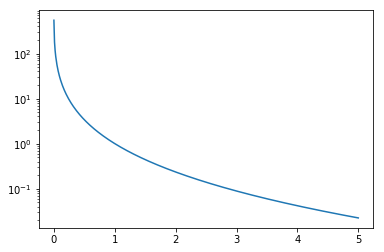

In [145]:
# make a sersic profile
# https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html
def b(n):
    return 1.9992*n-0.3271

def I(r):
    """Assuming that I_e=1.0 and that R_e=1.0"""
    n = 4
    return np.exp(-b(n) * (np.power(r, 1/n)  - 1))

r = np.linspace(0.001, 5, 500)
f = I(r) 

value_at_r1 = f[np.square(r-1).argmin()]
print(f'Value nearest R=1:  {value_at_r1}')

plt.semilogy(r, f)
plt.show()

R_e found at: 0.9911782356471296


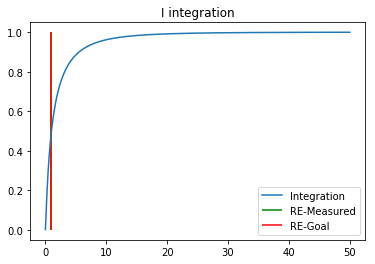

In [140]:
# integrate
delta_r = np.diff(r)[0]/2
#rs = [r[0]**2 * np.pi]
rs = [np.pi*((_r+delta_r)**2-(_r-delta_r)**2) for _r in r]
#rs.extend([np.pi*((r2-delta_r)**2-(r1-delta_r)**2) for r1, r2 in zip(r[:-1], r[1:])])
rs = np.array(rs)

rf = rs*f
I_tot = rf.sum()
int_I = np.cumsum(rf/I_tot)
re_idx = np.square(int_I-0.5).argmin()
re = r[re_idx]

print(f'R_e found at: {re}')
plt.title('I integration')
plt.plot(r, int_I, label='Integration')
plt.vlines(re, 0, 1, color='g', label='RE-Measured')
plt.vlines(1, 0, 1, color='r', label='RE-Goal')
plt.legend()
plt.show()

# Run Color Profile Graph On Actual Image

In [46]:
from astropy.io import fits

# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import ImageTools as it
import DataTools as dt

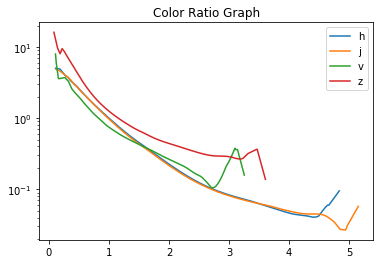

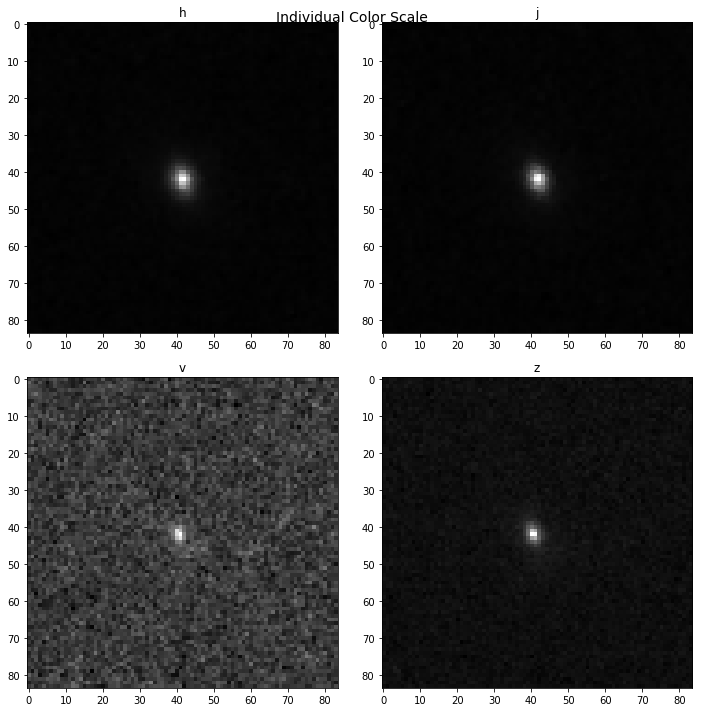

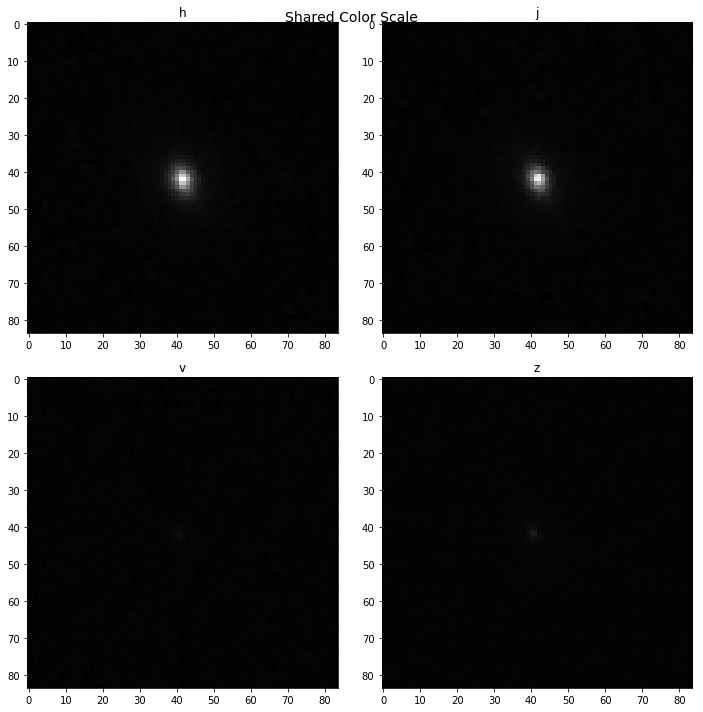

In [63]:
# get image
f_mask = 'img/GDS_wide2_2080_{}.fits'
bands = ['h', 'j', 'v', 'z']
img = {b:fits.getdata(f_mask.format(b)) for b in bands + ['segmap']}
src_map = img['segmap']==2080

plt.figure()
plt.title('Color Ratio Graph')
vmin, vmax = 0,0
for b in bands:
    vmin = min(vmin, np.min(img[b]))
    vmax = max(vmax, np.max(img[b]))
    rs, fs, ie, re = it.rs_fs_ie_re(img[b], src_map)
    rs /= re
    fs /= ie
    fs = dt.loessc(rs, fs, 1.5)
    plt.semilogy(rs, fs, label=b)
plt.legend()

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = np.array(axes).flatten()

for b in bands:
    a = axes[bands.index(b)]
    a.set_title(b)
    a.imshow(img[b], cmap='gray')

fig.suptitle('Individual Color Scale', fontsize=14)
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = np.array(axes).flatten()

for b in bands:
    a = axes[bands.index(b)]
    a.set_title(b)
    a.imshow(img[b], vmin=vmin, vmax=vmax, cmap='gray')

fig.suptitle('Shared Color Scale', fontsize=14)
fig.tight_layout()
plt.show()

# Adjust The R Values To Fit $R_e$=1

In [83]:
import gphelper as gp
importlib.reload(gp)

<module 'gphelper' from '../gphelper.py'>

/home/ryanhausen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:339: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


Drawing Samples.    
Seed:325507861


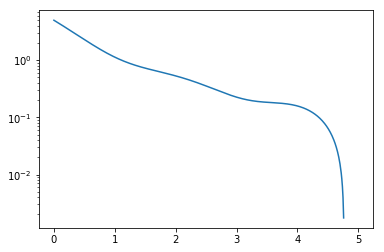

In [141]:
h_model = gp.GPHelper(restore_file='./gp-models/gp_h.json')
x = np.linspace(0.001, 5, 500)[:, np.newaxis]
h_line = h_model.sample(x)

plt.semilogy(x, h_line)
plt.show()

RE:[ 1.87437275]


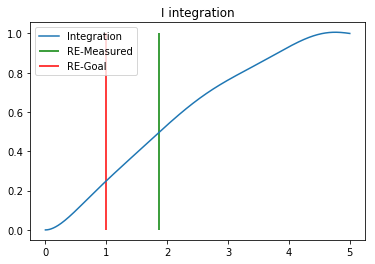

In [142]:
xs = [x[0]**2 * np.pi]
xs.extend([np.pi*(r2**2-r1**2) for r1, r2 in zip(x[:-1], x[1:])])
xs = np.array(xs)

rad_h = xs*h_line
I_tot = (rad_h).sum()
int_I = np.cumsum(rad_h/I_tot)
re_idx = np.square(int_I-0.5).argmin()
re = x[re_idx]

print(f'RE:{re}')
plt.title('I integration')
plt.plot(x, int_I, label='Integration')
plt.vlines(re, 0, 1, color='g', label='RE-Measured')
plt.vlines(1, 0, 1, color='r', label='RE-Goal')
plt.legend()
plt.show()

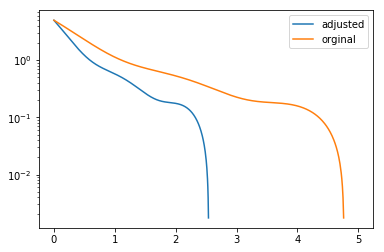

In [143]:
_x = x/re
plt.semilogy(_x, h_line, label='adjusted')
plt.semilogy(x, h_line, label='orginal')
plt.legend()
plt.show()

RE:[ 1.]


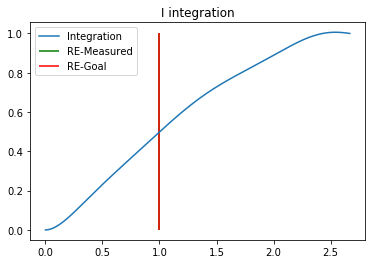

In [144]:
_xs = [_x[0]**2 * np.pi]
_xs.extend([np.pi*(r2**2-r1**2) for r1, r2 in zip(_x[:-1], _x[1:])])
_xs = np.array(_xs)

rad_h = _xs*h_line
I_tot = (rad_h).sum()
int_I = np.cumsum(rad_h/I_tot)
re_idx = np.square(int_I-0.5).argmin()
re = _x[re_idx]

print(f'RE:{re}')
plt.title('I integration')
plt.plot(_x, int_I, label='Integration')
plt.vlines(re, 0, 1, color='g', label='RE-Measured')
plt.vlines(1, 0, 1, color='r', label='RE-Goal')
plt.legend()
plt.show()

### Try Adding A Sersic Profile

In [ ]:
def opt_profile(s_coef):
    _f = s_coef * f
    